### EM-213: Advanced Topics Data Analytics
###### Alejandro Colina-Valeri
###### Nicholas Paneral
###### Kevin Smith

<h1 align="center"> Application of Cargo Shipping Classification</h1> 


## Problem Statement

Current events are bringing renewed focus on the amount of ships being stationary outside of ports on the west coast of the United States. There are also growing concerns about monitoring cargo traffic off the coast of China. In this project we want to evaluate the efficacy of machine learning to leverage satellite imagery to gauge traffic at major shipping ports around the world. To begin solving this problem, an image identification task is modeled, balanced, tested, and trained using CNN convolutional layers on an open source dataset (https://www.kaggle.com/apollo2506/satellite-imagery-of-ships).

### Primary Research Question

#### What are effective machine learning strategies for classifying cargo ships in satellite images? 

We investigate this question by training a CNN using two different sets of input data.

##### Experiment 1: normalized greyscale transformed using Histogram of Oriented Gradients
  
We are interested in experiment 1 becuase it may be faster to train the CNN on this lower dimensional data (greyscale vs rgb) and the shape of the ships may lend themselves well to indentification via oriented gradients.
  
 
##### Experiment 2: using normalized RGB values
Experiment 2 reflects a default benchmark with minimal processing to normalize the RGB values in the original dataset.

## Required Modules

In [5]:
import os
import math
from zipfile import ZipFile
import pickle
import bz2
import json

import numpy.testing as npt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from skimage import color
from skimage.feature import hog
from skimage.transform import resize

import sklearn
from sklearn import model_selection
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, Activation
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam, SGD

## Set Global Filepaths and Methods

In [6]:
# expected file paths
DATA_ROOT_DIRECTORY: str = 'data'
COMPRESSED_DATA_DIRECTORY_PATH: str = os.path.join(DATA_ROOT_DIRECTORY, 'compressed')
COMPRESSED_MANIFEST_FILE_PATH: str = os.path.join(COMPRESSED_DATA_DIRECTORY_PATH, 'shipnet_manifest.pbz2')
COMPRESSED_IMAGES_FILE_PATH: str = os.path.join(COMPRESSED_DATA_DIRECTORY_PATH, 'shipnet_images.zip')

# file paths to create
UNCOMPRESSED_DATA_DIRECTORY_PATH: str = os.path.join(DATA_ROOT_DIRECTORY, 'uncompressed')
UNCOMPRESSED_MANIFEST_FILE_PATH: str = os.path.join(UNCOMPRESSED_DATA_DIRECTORY_PATH, 'shipnet.json')
UNCOMPRESSED_IMAGES_DIRECTORY_PATH: str = os.path.join(UNCOMPRESSED_DATA_DIRECTORY_PATH, 'shipnet')

# trained model location
TRAINED_MODEL_DIRECTORY_PATH: str = os.path.join(DATA_ROOT_DIRECTORY, 'trained')
TRAINED_HOG_DIRECTORY_PATH: str = os.path.join(TRAINED_MODEL_DIRECTORY_PATH, 'hog') # HOG model (experiment 1)
TRAINED_RGB_DIRECTORY_PATH: str = os.path.join(TRAINED_MODEL_DIRECTORY_PATH, 'rgb') # RGB model (experiment 2)
    
    
def get_full_path(local_path: str):
    """
    Gets the full path from the local path.

    :param local_path: a string pointing to a path local to this Notebook
    :returns: a string pointing to the full path corresponding to the provided local path
    """
    return os.path.join(os.getcwd(), local_path)

def raise_file_not_found_error_for_path(expected_object: str, local_path: str):
    """
    Raises a descriptive file not found error using the provided

    :param expected_object: a string fragment describing the content of the expected file
    :param local_path: the path that was not found
    :return: None.
    :raises FileNotFoundError
    """
    raise FileNotFoundError(f'Could not find {expected_object} at the specified path: {get_full_path(local_path)}')

## Unzipping Data 

We need to compress the data in order to store it in GitHub. 

We will use the following modules:
 - __zipfile__ to decompress the archive of the training images
 - __pickle__ and __bz2__ to decompress the JSON object containing the manifest of images and their lables
 - __os__ to handle filepath and directory manipulation
 - __json__ to read / write JSON manifest
 

In [7]:
def deflate_manifest():
    """
    Deflates the compressed manifest file using bz2 decompression. Note this will create a ~350 MB file in the
    UNCOMPRESSED_DATA_DIRECTORY_PATH.

    :return: None.
    """
    with bz2.BZ2File(COMPRESSED_MANIFEST_FILE_PATH, 'rb') as input_file:
        with open(UNCOMPRESSED_MANIFEST_FILE_PATH, 'w') as output_file:
            json.dump(pickle.load(input_file), output_file)
    return None


def deflate_images():
    """
    Deflates the compressed images file using zip decompression. Note this will create 4000 images in the
    UNCOMPRESSED_IMAGES_DIRECTORY_PATH directory.

    :return: None.
    """
    with ZipFile(COMPRESSED_IMAGES_FILE_PATH, 'r') as input_file:
        input_file.extractall(UNCOMPRESSED_IMAGES_DIRECTORY_PATH)
    return None


def check_and_deflate_all():
    """
    Checks for expected input files and a non-existent UNCOMPRESSED_DATA_DIRECTORY_PATH directory, then
    deflates the manifest and images. 

    :raises FileNotFoundError if expected input files are not found
    :raises FileExistsError if UNCOMPRESSED_DATA_DIRECTORY_PATH exists
    :returns: None.
    """

    # check if compressed data directory exists
    if os.path.isdir(COMPRESSED_DATA_DIRECTORY_PATH):

        # if so, check for compressed manifest file
        if not os.path.isfile(COMPRESSED_MANIFEST_FILE_PATH):
            raise_file_not_found_error_for_path('the compressed manifest file', COMPRESSED_MANIFEST_FILE_PATH)

        # and compressed images file
        if not os.path.isfile(COMPRESSED_IMAGES_FILE_PATH):
            raise_file_not_found_error_for_path('the compressed images file', COMPRESSED_IMAGES_FILE_PATH)

    else:
        raise raise_file_not_found_error_for_path('the compressed data directory', COMPRESSED_DATA_DIRECTORY_PATH)

    # check if uncompressed data directory exists
    if os.path.isdir(UNCOMPRESSED_DATA_DIRECTORY_PATH):
        raise FileExistsError(('The path to the output directory already exists: '
                               f'{get_full_path(UNCOMPRESSED_DATA_DIRECTORY_PATH)}. If you are sure you want to run this step '
                               'please remove this directory manually - we will not overwrite it.'))

    # inflate files
    else:
        os.mkdir(UNCOMPRESSED_DATA_DIRECTORY_PATH)
        deflate_manifest()
        deflate_images()

    return None

In [8]:
check_and_deflate_all()

## Load & Visually Inspect Data 
   - Note the previous step only needs to be run once to generate __/data/uncompressed__. 
   - In this step we will read in the data and check it against the manifest.
 

### Load in Manifest
This should match the shipsnet.json file from https://www.kaggle.com/rhammell/ships-in-satellite-imagery/. 

The manifest JSON is expected to contain the following key-value mappings:

  - __data__: 4000 vectors of length 19200, representing 80 x 80 pixel images with 3 color channels (RGB)
  - __labels__: a vector of length 4000 with 1 if the corresponding image in __data__ is a ship, and 0 if it is not a ship.
  - __scene__: a vector of length 4000 specifying the scene the corresponding image in __data__ was extracted from 
  - __locations__: a vector of dimension 4000 x 2 containing the longitude and latitude (unspecified, presumed WGS 84) of the the centerpoint of the corresponding image in __data__ 

In [ ]:
# read in the manifest
with open(UNCOMPRESSED_MANIFEST_FILE_PATH, 'r') as f:
    manifest = json.load(f)

### Show & Validate Manifest Keys

In [ ]:
EXPECTED_MANIFEST_KEYS = ['data', 'labels', 'locations', 'scene_ids']
print(f'The manifest contains the following keys: {manifest.keys()}')

# assert matches expectations
npt.assert_array_equal(list(manifest.keys()), EXPECTED_MANIFEST_KEYS)

### Show & Validate Labels

In [94]:
EXPECTED_NUMBER_OF_IMAGES = 4000
NO_SHIP_KEY = "No Ship";
SHIP_KEY = "Ship"
EXPECTED_LABEL_TYPES = {NO_SHIP_KEY: 0, SHIP_KEY: 1}

# extract labels
manifest_labels = np.array(manifest['labels']).astype('uint8')

# assert on label size and type
num_labels = len(manifest_labels)
unique_labels = np.unique(manifest_labels)
npt.assert_array_equal(num_labels, EXPECTED_NUMBER_OF_IMAGES)
npt.assert_array_equal(unique_labels, list(EXPECTED_LABEL_TYPES.values()))

print(f'The manifest contains: {num_labels} labels of types {unique_labels}')

The manifest contains: 4000 labels of types [0 1]


### Show and Validate Images

In [ ]:
NUMBER_OF_PIXELS_HEIGHT = 80
NUMBER_OF_PIXELS_WIDTH = 80
NUMBER_OF_COLOR_CHANNELS = 3
EXPECTED_BYTES_PER_IMAGE = NUMBER_OF_PIXELS_HEIGHT * NUMBER_OF_PIXELS_WIDTH * NUMBER_OF_COLOR_CHANNELS

# extract images
manifest_images = np.array(manifest['data']).astype('uint8')

num_images = len(manifest_images)
unique_bytes_per_images = np.unique([len(img) for img in manifest_images])

# check the expected number of images are available
npt.assert_array_equal(num_images, EXPECTED_NUMBER_OF_IMAGES)

# check there is only one unique image size
npt.assert_array_equal(len(unique_bytes_per_images), 1)
# ... and that it is the expected size
npt.assert_array_equal(unique_bytes_per_images[0], EXPECTED_BYTES_PER_IMAGE)

print(f'The manifest contains: {num_images} of containing {unique_bytes_per_images[0]} bytes.')

# map to array of shape num_images * NUMBER_OF_COLOR_CHANNELS * NUMBER_OF_PIXELS_WIDTH * NUMBER_OF_PIXELS_HEIGHT
dataset = manifest_images.reshape([-1, NUMBER_OF_COLOR_CHANNELS, NUMBER_OF_PIXELS_WIDTH, NUMBER_OF_PIXELS_HEIGHT])

# then to an array of shape num_images, NUMBER_OF_PIXELS_WIDTH, NUMBER_OF_PIXELS_HEIGHT, NUMBER_OF_COLOR_CHANNELS
dataset = dataset.transpose(0,2,3,1)
                                   
print((f'The manifest has been converted to a array of images of shape: {(dataset.shape)}. '
      '\n - The first dimension is the image index. '
      '\n - The second dimension is the pixel width index. '
      '\n - The third dimension is the pixel height index. '
      '\n - The fourth dimension is the color channel index (R,G,B).'))


The first image of a ship is index 0:


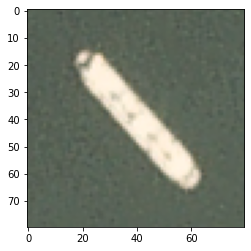

In [19]:
first_image_index_of_ship = np.where(manifest_labels==1)[0][0]
print(f'The first image of a ship is index {first_image_index_of_ship}:')
plt.imshow(dataset[first_image_index_of_ship,:,:,:])

The first image of a non-ship is index 1000:


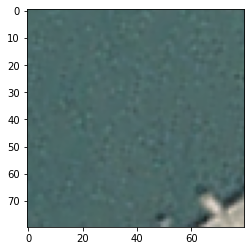

In [20]:
first_image_index_of_non_ship = np.where(manifest_labels==0)[0][0]
print(f'The first image of a non-ship is index {first_image_index_of_non_ship}:')
plt.imshow(dataset[first_image_index_of_non_ship,:,:,:])

## Data Cleaning

Our data cleaning has the following steps: 
  * Create categorical variables out of the labels using one-hot encoding
  * Normalize the channel values by mapping [0, 255] to [0, 1]
  * Create a greyscale version of the normalized values
  * Apply the Histogram of Oriented Gradients (HOG) algorithm to those normnalized greyscale values


### Categorical Labels

We will make the labels categorical using one-hot encoding. 


In [135]:
categorical_labels = keras.utils.to_categorical(
    manifest_labels, 
    num_classes=len(EXPECTED_LABEL_TYPES))

### Normalization

We will normalize all RGB values originally in the range of [0, 255] to [0, 1] by  dividing all values by 255. 

In [22]:
minimum_raw_value = np.min(dataset)
maximum_raw_value = np.max(dataset)
normalized_dataset_rgb = dataset / maximum_raw_value
minimum_normalized_value = np.min(normalized_dataset_rgb)
maximum_normalized_value = np.max(normalized_dataset_rgb)
print(f'The minimum and maximum RGB values in the raw dataset are {minimum_raw_value} and {maximum_raw_value}.')
print(f'The minimum and maximum RGB values in the normalized dataset are {minimum_normalized_value} and {maximum_normalized_value}.')

The minimum and maximum RGB values in the raw dataset are 1 and 255.
The minimum and maximum RGB values in the normalized dataset are 0.00392156862745098 and 1.0.


### Preparation for Experiment 1: Histogram of Oriented Gradients (HOG)
#### Convert RGB to Greyscale

In [23]:
normalized_dataset_greyscale = [ color.rgb2gray(i) for i in normalized_dataset_rgb ]
normalized_dataset_greyscale = np.array(normalized_dataset_greyscale)

#### Apply HOG to Greyscale Dataset

In [24]:
NUMBER_OF_ORIENTATIONS = 8
PIXELS_PER_CELL = 16
CELLS_PER_BLOCK = 4
NORM = "L2"

hog_images = []
hog_features = []
for image in normalized_dataset_greyscale:
    feature,hog_image = hog(image, orientations=NUMBER_OF_ORIENTATIONS, 
                       pixels_per_cell=(PIXELS_PER_CELL,PIXELS_PER_CELL),
                       cells_per_block=(CELLS_PER_BLOCK, CELLS_PER_BLOCK),
                       block_norm= NORM,visualize=True)
    hog_images.append(hog_image)
    hog_features.append(feature)

#### Create Function to Plot Original vs. Greyscale vs. HOG

In [25]:
def plot_original_vs_greyscale_vs_hog(image_index: int):
    """
    Plots the same image drawn from the original dataset, the normalized grayscale
    dataset and the HOG dataset. 

    :param image_index: an integer indicating the index of the image to plot
    :returns: None.
    """
    FIGURE_WIDTH = 12
    FIGURE_HEIGHT = 4
    NUMBER_OF_SUBPLOTS = 3
    NROWS = 1
    
    fig, axes = plt.subplots(NROWS, NUMBER_OF_SUBPLOTS, figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
    ax = axes.ravel()

    ax[0].imshow(dataset[image_index])
    ax[0].set_title("Original")
    ax[1].imshow(normalized_dataset_greyscale[image_index], cmap='gray')
    ax[1].set_title("Grayscale")
    ax[2].imshow(hog_images[image_index], cmap='gray')
    ax[2].set_title("HOG")
    fig.tight_layout()
    plt.show()

#### Plot Comparison of First Image of Ship

Note: HOG shows strong vectors in the direction of the ship, and not elsewhere. This is a good sign. 

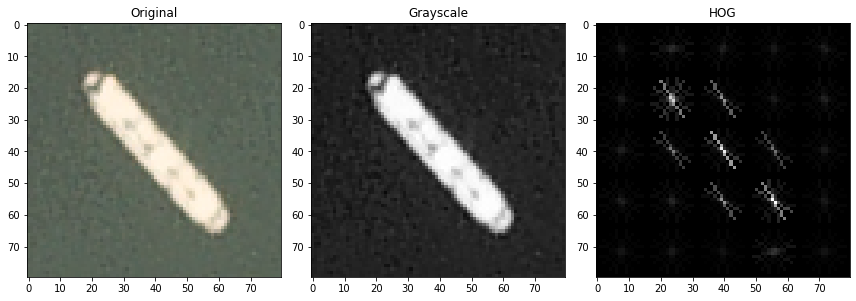

In [26]:
plot_original_vs_greyscale_vs_hog(first_image_index_of_ship)

#### Plot Comparison of First Image of Non-Ship
Note: HOG shows weak vectors over the water, and mixed vectors over the small patch of land. This also looks promising. 

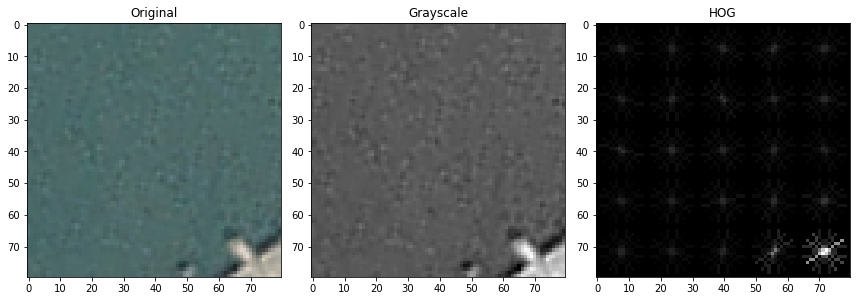

In [27]:
plot_original_vs_greyscale_vs_hog(first_image_index_of_non_ship)

## Building Training , Test, and Validation Datasets

We adopt an 80-10-10 approach for splitting our dataset into training, validation, and test. 


### Add method for splitting datasets

In [55]:
TEST_FRACTION = 0.20
VALIDATION_FRACTION_OF_NON_TEST_DATASET = 0.25

TRAINING_IMAGES_KEY = 'training_images'
TRAINING_LABELS_KEY = 'training_labels'
VALIDATION_IMAGES_KEY = 'validation_images'
VALIDATION_LABELS_KEY = 'validation_labels'
TEST_IMAGES_KEY = 'test_images'
TEST_LABELS_KEY = 'test_labels'

def split_dataset(images, categorical_labels):
    """
    Splits a dataset consisting of images and categorical labels into training,
    test, and validation sets. 

    :param images: The images dataset to split.  
    :param categorical_labels: A set of categorical labels corresponding to the images.  
    :returns: A dictionary containing dataset splits.  
    """

    RANDOM_SEED = 42 # for reproducibility; https://en.wikipedia.org/wiki/42_(number)#The_Hitchhiker's_Guide_to_the_Galaxy

    # Doing an initial split to create the test dataset
    train_and_validate_images, test_images, train_and_validate_labels, test_labels = \
        model_selection.train_test_split(images, 
                                         categorical_labels, 
                                         test_size=TEST_FRACTION, 
                                         random_state=RANDOM_SEED)

    # Doing a split on the remainder to create train and validation datasets
    training_images, validation_images, training_labels, validation_labels = \
        sklearn.model_selection.train_test_split(train_and_validate_images, 
                                                 train_and_validate_labels, 
                                                 test_size=VALIDATION_FRACTION_OF_NON_TEST_DATASET, 
                                                 random_state=RANDOM_SEED)

    splits = {
        TRAINING_IMAGES_KEY: training_images,
        TRAINING_LABELS_KEY: training_labels,
        VALIDATION_IMAGES_KEY: validation_images, 
        VALIDATION_LABELS_KEY: validation_labels,
        TEST_IMAGES_KEY: test_images,
        TEST_LABELS_KEY: test_labels
    }
    
    return splits

### Add method for validating dataset splits

In [56]:
EXPECTED_TEST_SET_SIZE = TEST_FRACTION * EXPECTED_NUMBER_OF_IMAGES
EXPECTED_VALIDATION_SET_SIZE = (EXPECTED_NUMBER_OF_IMAGES - EXPECTED_TEST_SET_SIZE) * \
VALIDATION_FRACTION_OF_NON_TEST_DATASET
EXPECTED_TRAINING_SET_SIZE = EXPECTED_NUMBER_OF_IMAGES - EXPECTED_VALIDATION_SET_SIZE - EXPECTED_TEST_SET_SIZE

def validate_splits(splits):
    """
    Splits a dataset consisting of images and categorical labels into training,
    test, and validation sets. 

    :param splits: A dictionary containing dataset splits.
    :returns: None
    :raises AssertionError if assertions on splits are not met
    """
    
    assert len(splits['validation_images']) == EXPECTED_VALIDATION_SET_SIZE, 'unexpected validation set size'
    assert len(splits['test_images']) == EXPECTED_TEST_SET_SIZE, 'unexpected test set size'
    assert len(splits['training_images']) == EXPECTED_TRAINING_SET_SIZE, 'unexpected training set size'
    
    return None

### Validate Expected Splits

In [57]:
hog_splits = split_dataset(hog_images, categorical_labels)
rgb_splits = split_dataset(normalized_dataset_rgb, categorical_labels)

validate_splits(hog_splits)
validate_splits(rgb_splits)

print((f'Both datasets have been split into {int(EXPECTED_VALIDATION_SET_SIZE)} validation images, '
      f'{int(EXPECTED_TEST_SET_SIZE)} test images, and {int(EXPECTED_TRAINING_SET_SIZE)} training images'))

Both datasets have been split into 800 validation images, 800 test images, and 2400 training images


###  Reshape HOG Dataset with Explicit Greyscale Channel for CNN

We want to go from (number_of_images, NUMBER_OF_PIXELS_HEIGHT, NUMBER_OF_PIXELS_WIDTH) to (number_of_images, NUMBER_OF_PIXELS_HEIGHT, NUMBER_OF_PIXELS_HEIGHT, 1), because the CNN wants an explicit channel for our greyscale data. 

In [58]:
NUMBER_OF_GREY_CHANNELS = 1

def add_explicit_channel_for_greyscale(dataset):
    """
    Adds an explicit dimension to a dataset for the greyscale channel. 

    :param image_index: The dataset to transform. 
    :returns: A transformed dataset. 
    """
    
    dataset_reshaped  = np.reshape(dataset, 
                                   newshape = (-1, 
                                    NUMBER_OF_PIXELS_HEIGHT, 
                                    NUMBER_OF_PIXELS_WIDTH, 
                                    NUMBER_OF_GREY_CHANNELS))
    return dataset_reshaped

hog_splits[TEST_IMAGES_KEY] = add_explicit_channel_for_greyscale(hog_splits[TEST_IMAGES_KEY])
hog_splits[VALIDATION_IMAGES_KEY] = add_explicit_channel_for_greyscale(hog_splits[VALIDATION_IMAGES_KEY])
hog_splits[TRAINING_IMAGES_KEY] = add_explicit_channel_for_greyscale(hog_splits[TRAINING_IMAGES_KEY])

## Define a Common CNN Model for Experiments

We utilized a CNN with the following types of layers: 
* ConV2D - specifies a convolutional layer, batch normalization and activation layers in one function with the fliters, kernel size, and strides.

* MaxPooling2D – specifies a layer for reducing the spatial dimensions of the activation map without losing information

* Dropout – specifies a layer that removes a portion of links between neurons

* Flatten - specifies a layer to flatten the input so that is equal to the number of elements contained in tensor not including the batch dimension

* Dense - specifies a full (dense) layer

We used the following activation functions: 
* relu - rectified linear unit, for intermediate layers
* softmax - a common choice for a final output layer of a classification network

We use Adam as the optimizer and binary cross entropy as the loss function.

This CNN model is based on the prior work of: https://www.kaggle.com/windywalks/ship-satellite-image-classification-98-3

### Add Method for Building Common CNN Model

In [59]:
N_EPOCHS = 50

def build_cnn_model(number_of_channels: int):
    """
    Builds a convolutional neural network model for each of the experiments, 
    which differ only by the specified number of channels. 

    :param number_of_channels: The number of color channels to anticipate.
    :returns: A compiled Keras model of a convolutional neural network.
    """

    DROPOUT_LEVEL = 0.25
    
    # for initial Conv2D layer
    INITIAL_FILTER_SIZE = 64
    INITIAL_KERNEL_SIZE = (5, 5)
    
    # for initial MaxPooling2D layer
    INITIAL_POOL_SIZE = (3, 3)
    
    # for subsequent Conv2D layers
    SECONDARY_FILTER_SIZE = 32
    SECONDARY_KERNEL_SIZE = (3, 3)
    
    # for subsequent MaxPooling2D layers
    SECONDARY_POOL_SIZE = (2, 2)
    
    # image shape
    input_shape = (NUMBER_OF_PIXELS_HEIGHT, NUMBER_OF_PIXELS_WIDTH, number_of_channels)

    # use sequential API
    model = Sequential()
    
    # add initial Conv2D layer
    model.add(Conv2D(filters = INITIAL_FILTER_SIZE, 
                     kernel_size = INITIAL_KERNEL_SIZE, 
                     input_shape = input_shape, 
                     activation='relu'))
    
    model.add(MaxPooling2D(pool_size=INITIAL_POOL_SIZE))
    model.add(Dropout(DROPOUT_LEVEL))
    
    # add secondary Conv2D layer
    model.add(Conv2D(filters = SECONDARY_FILTER_SIZE, 
                     kernel_size = SECONDARY_KERNEL_SIZE, 
                     input_shape=input_shape, 
                     activation='relu')) 
    model.add(MaxPooling2D(pool_size=SECONDARY_POOL_SIZE))
    model.add(Dropout(DROPOUT_LEVEL))
    
    # add tertiary Conv2D layer
    model.add(Conv2D(filters = SECONDARY_FILTER_SIZE,
                     kernel_size = SECONDARY_KERNEL_SIZE, 
                     input_shape=input_shape, 
                     activation='relu')) 
    
    model.add(MaxPooling2D(pool_size=SECONDARY_POOL_SIZE))
    
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(DROPOUT_LEVEL))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(DROPOUT_LEVEL))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(DROPOUT_LEVEL))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    return model

### Add Method for Fitting a CNN Model using Dataset Splits

In [60]:
MODEL_KEY = 'model'
HISTORY_KEY = 'history'

def fit_model_to_splits(model, splits):
    """
    Fits a convolutional neural network model to the training data
    in the splits dictionary. 

    :param splits: A dictionary containing dataset splits.
    :returns: A dictionary containing a trained model and its history.  
    """
    validation_data=(splits[VALIDATION_IMAGES_KEY], 
                     splits[VALIDATION_LABELS_KEY])
    
    history = model.fit(splits[TRAINING_IMAGES_KEY], 
                        splits[TRAINING_LABELS_KEY], 
                        epochs=N_EPOCHS, 
                        validation_data = validation_data)
                            
    
    return {MODEL_KEY: model, HISTORY_KEY: history}

## Conduct Experiments 

### Experiment 1: CNN with Greyscale HOG

#### Build & Train the Model

In [65]:
hog_results = fit_model_to_splits(
    build_cnn_model(NUMBER_OF_GREY_CHANNELS), 
    hog_splits)

Epoch 1/50
75/75 [==============================] - 5s 71ms/step - loss: 0.5663 - accuracy: 0.7533 - val_loss: 0.4325 - val_accuracy: 0.7513
Epoch 2/50
75/75 [==============================] - 5s 72ms/step - loss: 0.3097 - accuracy: 0.8492 - val_loss: 0.2457 - val_accuracy: 0.8950
Epoch 3/50
75/75 [==============================] - 5s 67ms/step - loss: 0.2051 - accuracy: 0.9150 - val_loss: 0.2205 - val_accuracy: 0.8975
Epoch 4/50
75/75 [==============================] - 6s 76ms/step - loss: 0.1680 - accuracy: 0.9287 - val_loss: 0.1943 - val_accuracy: 0.9250
Epoch 5/50
75/75 [==============================] - 5s 70ms/step - loss: 0.1645 - accuracy: 0.9346 - val_loss: 0.1942 - val_accuracy: 0.9337
Epoch 6/50
75/75 [==============================] - 5s 72ms/step - loss: 0.1290 - accuracy: 0.9475 - val_loss: 0.1222 - val_accuracy: 0.9538
Epoch 7/50
75/75 [==============================] - 5s 67ms/step - loss: 0.0958 - accuracy: 0.9600 - val_loss: 0.1334 - val_accuracy: 0.9538
Epoch 8/50
75

### Experiment 2: CNN with Normalized RGB

In [66]:
rgb_results = fit_model_to_splits(
    build_cnn_model(NUMBER_OF_COLOR_CHANNELS), 
    rgb_splits)

Epoch 1/50
75/75 [==============================] - 6s 82ms/step - loss: 0.5169 - accuracy: 0.7829 - val_loss: 0.3355 - val_accuracy: 0.8863
Epoch 2/50
75/75 [==============================] - 6s 78ms/step - loss: 0.3469 - accuracy: 0.8579 - val_loss: 0.2553 - val_accuracy: 0.9062
Epoch 3/50
75/75 [==============================] - 6s 79ms/step - loss: 0.2435 - accuracy: 0.8954 - val_loss: 0.2233 - val_accuracy: 0.9200
Epoch 4/50
75/75 [==============================] - 6s 81ms/step - loss: 0.2039 - accuracy: 0.9050 - val_loss: 0.2462 - val_accuracy: 0.9062
Epoch 5/50
75/75 [==============================] - 6s 78ms/step - loss: 0.1929 - accuracy: 0.9225 - val_loss: 0.2678 - val_accuracy: 0.8950
Epoch 6/50
75/75 [==============================] - 6s 81ms/step - loss: 0.1667 - accuracy: 0.9413 - val_loss: 0.1567 - val_accuracy: 0.9388
Epoch 7/50
75/75 [==============================] - 6s 78ms/step - loss: 0.1329 - accuracy: 0.9492 - val_loss: 0.1568 - val_accuracy: 0.9450
Epoch 8/50
75

## Save Results

Note, we will not overwrite existing data. 

In [246]:
if not os.path.isdir(TRAINED_HOG_DIRECTORY_PATH):
    hog_results[MODEL_KEY].save(TRAINED_HOG_DIRECTORY_PATH)
else:
    print('Not saving HOG model, becuase previous model already exists at the specified location.')
    
if not os.path.isdir(TRAINED_RGB_DIRECTORY_PATH):
    rgb_results[MODEL_KEY].save(TRAINED_RGB_DIRECTORY_PATH)
else:
    print('Not saving RGB model, becuase previous model already exists at the specified location.')

INFO:tensorflow:Assets written to: data\trained\hog\assets
INFO:tensorflow:Assets written to: data\trained\rgb\assets


## Compare Results
If you have re-run this analysis, the results may be inconsistent with the printed text. Please refer to https://github.com/acolin02/EM213-Final_Project/blob/main/Ship%20Analysis.ipynb for the original results that match the text. 

### Training Times

Despite the reduced dimensionality of the HOG dataset versus the RGB, training time was only marginally faster for HOG.

### Model Training Histories

Accuracy shows the number of correct predictions obtained and loss indicates the difference from the desired target state and how the model behaves after each iteration.

#### HOG


<AxesSubplot:>

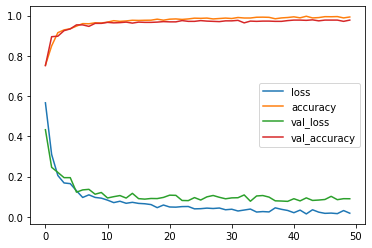

In [68]:
hog_history = hog_results['history']
pd.DataFrame(hog_history.history).plot()

#### RGB

<AxesSubplot:>

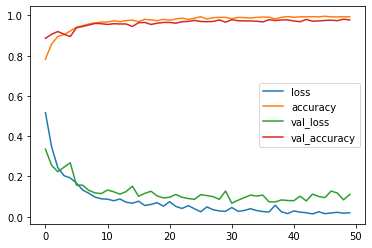

In [131]:
rgb_history = rgb_results['history']
pd.DataFrame(rgb_history.history).plot()

### Evaluating Performance on Test Data

#### Overall Performance

The overall performance on the test data is high. Both models achieved an accuracy greater than 98% and a loss less than 10%. 


In [70]:
hog_model = hog_results['model']
hog_test_loss, hog_test_accuracy = hog_model.evaluate(
    hog_splits[TEST_IMAGES_KEY], 
    hog_splits[TEST_LABELS_KEY])

25/25 [==============================] - 0s 14ms/step - loss: 0.0372 - accuracy: 0.9875


In [72]:
rgb_model = rgb_results['model']
rgb_test_loss, rgb_test_accuracy = rgb_model.evaluate(
    rgb_splits[TEST_IMAGES_KEY], 
    rgb_splits[TEST_LABELS_KEY])

25/25 [==============================] - 0s 13ms/step - loss: 0.0713 - accuracy: 0.9825


#### Get Actual and Predicted Labels for Test Data

In [101]:
ACTUAL_LABELS_KEY = 'actual_labels'
PREDICTED_LABELS_KEY = 'predicted_labels'

def get_predicted_and_actual_labels(model, splits):
    """
    Gets the predicted and actual albels for the given model and splits. 

    :param model: A trained model. 
    :param splits: A dictionary containing dataset splits.
    :returns: A dictionary containing the predicted and actual labels. 
    """
    COMMON_AXIS = 1 # we'll compare predictions in the first one-hot column 
                    #(this is arbitrary, we only have 2 categories, so either would work)
    
    predicted_labels = np.argmax(model.predict(splits[TEST_IMAGES_KEY]), axis = COMMON_AXIS)
    actual_labels = np.argmax(splits[TEST_LABELS_KEY], axis = COMMON_AXIS)
    
    return { ACTUAL_LABELS_KEY: actual_labels, PREDICTED_LABELS_KEY: predicted_labels }

hog_label_test_results = get_predicted_and_actual_labels(hog_model, hog_splits)
rgb_label_test_results = get_predicted_and_actual_labels(rgb_model, rgb_splits)

#### Add Method for Confusion Matrix Comparison

We utilize side-by-side confusion matrices to get insight into the different types of classification errors made by the models on the test data. 

In [129]:
def compare_confusion_matrices():
    """
    Plots confusion matrices for the HOG and RGB models on the test data. 

    :returns: None.
    """
    FIGURE_WIDTH = 10
    FIGURE_HEIGHT = 10
    NUMBER_OF_SUBPLOTS = 2
    NROWS = 1
    
    fig, axes = plt.subplots(NROWS, NUMBER_OF_SUBPLOTS, figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
    ax = axes.ravel()
    
    hog_matrix = metrics.confusion_matrix(
        hog_label_test_results[ACTUAL_LABELS_KEY], 
        hog_label_test_results[PREDICTED_LABELS_KEY])
    
    rgb_matrix = metrics.confusion_matrix(
        rgb_label_test_results[ACTUAL_LABELS_KEY], 
        rgb_label_test_results[PREDICTED_LABELS_KEY])
    
    hog_disp = metrics.ConfusionMatrixDisplay(
        confusion_matrix=hog_matrix, 
        display_labels=EXPECTED_LABEL_TYPES.keys())
    hog_disp.plot(ax=ax[0], cmap=plt.cm.Blues)
    hog_disp.ax_.set_title('HOG')
    hog_disp.im_.colorbar.remove()
    
    rgb_disp = metrics.ConfusionMatrixDisplay(
        confusion_matrix=rgb_matrix, 
        display_labels=EXPECTED_LABEL_TYPES.keys())
    rgb_disp.plot(ax=ax[1], cmap=plt.cm.Blues)
    rgb_disp.ax_.set_title('RGB')
    rgb_disp.im_.colorbar.remove()
    
    plt.show()

#### Confusion Matrix Comparison

Notes for interpreting the confusion matrices:
* The Expected result is on the vertical axis for True Label “No Ship” and “Ship”
* The predicted result is on the horizontal axis predicted label “No Ship” and “Ship”

##### Results

Compared with the RGB network, the HOG network appears to have a slight bias towards predicting "No Ship". If "No Ship" is the negative outcome, then the HOG network exhibits a higher true negative rate and a higher false negative rate than the RGB network. Meanwhile, the RGB network exhibits a higher true positive rate and a higher false positive rate. Overall, both networks perform comparably and with high accuracy. 

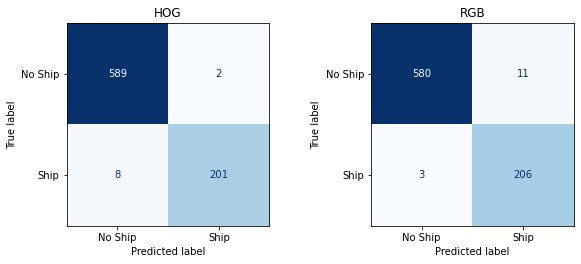

In [130]:
compare_confusion_matrices()

### Create Method to Investigate Errors in Test Dataset

In [227]:
def print_misclassified_test_predictions(test_results, splits):
    """
    Prints misclassified images from from the test set. The labels on each
    image represent its 'true' label in the original dataset.

    :param test_results: Test results calculated by get_predicted_and_actual_labels.
    :param splits: A dictionary containing dataset splits.
    :returns: None.
    """  
    NROW = 2
    
    predicted_labels = test_results[PREDICTED_LABELS_KEY]
    actual_labels = test_results[ACTUAL_LABELS_KEY]
    
    # finds the indices of non-zero elements
    # e.g. where the predictions differ
    bad_indices = np.argwhere(predicted_labels - actual_labels) 
                        
    test_images = splits[TEST_IMAGES_KEY];
    test_labels = splits[TEST_LABELS_KEY];

    nbad = len(bad_indices)
    ncol = math.ceil(nbad / NROW)
    
    FIGURE_WIDTH = 12
    FIGURE_HEIGHT = 4

    axis_index = 0
    fig, axes = plt.subplots(NROW, ncol, figsize = (FIGURE_WIDTH, FIGURE_HEIGHT))
    ax = axes.ravel()
    
    for img_index in bad_indices:

        # a value of one in the first one-hot column means "No Ship"
        ship_indicator = test_labels[img_index][0][0]
        label = "Ship"
        if(ship_indicator == 1):
            label = "No Ship"

        ax[axis_index].imshow(np.squeeze(test_images[img_index]))
        ax[axis_index].set_title(f'truth: {label}')
        axis_index += 1
        
    while axis_index < len(ax):
        ax[axis_index].axis('off')
        axis_index += 1
        
    fig.tight_layout(pad=1)
    plt.show()

### Exploring Misclassifications

#### HOG Errors

For the HOG algorithm we displayed both the HOG image and the original image to see what specific features the algorithm is misclassifying. 

One conclusion is that the algorithm is not good at classifying ships when they are zoomed in and take up most of the image. 4 of 8 ships are run from one edge to another edge of the picture which might be interpreted by the algorithm as a bridge. The other half of the ships seem to be blurry or have low resolution which might obstruct the accuracy of the HOG derivative mapping, and put less emphasis in certain pixels where a ship is located in the picture.

For the 2 images that are not ships, we can see from the HOG images that they represent a strong and straight derivative line, which may explain why the algorithm mistakenly classified them as ships


##### HOG Errors (raw)


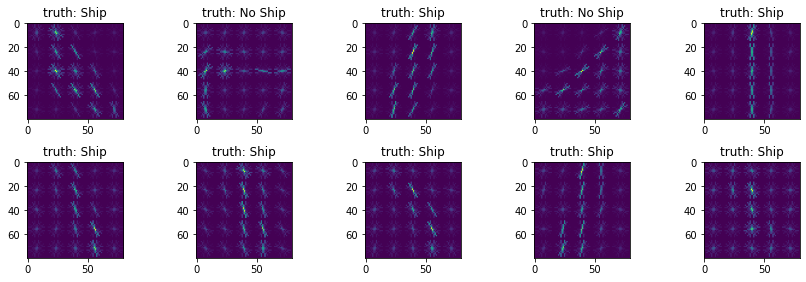

In [228]:
print_misclassified_test_predictions(hog_label_test_results, hog_splits)

##### HOG Errors (mapped to RGB equivalents)

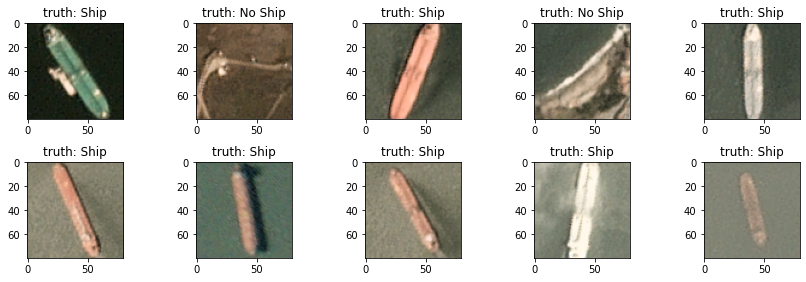

In [230]:
print_misclassified_test_predictions(hog_label_test_results, rgb_splits)

#### RGB Errors 

The RGB model, in contrast is worse at classifying “No ships”. Of the 11 false positives, 4 were partial ships (which the original dataset considers to be "No ships"), 4 are water bodies or waves, and 3 are bridges. This shows that the algorithm was unable to properly classify these 11 images because they all look very straight like a ship, and are concentrated in the middle of the picture.

For the 3 ships that algorithm incorrectly categorized as “No ships” all 3 are very zoomed in pictures, where the extent of the ship touches or nearly touches the boundary. The RGB algorithm may be confusing these with bridges, which often span the whole image. An alternative explanation is that all three are camouflaged becuase the top of the ship in each of these images is not very contrasted with the background (i.e., 2 are bluegreen on a bluegreen background and 1 is white on a foggy background).

Lastly, we can see that both algorithms failed to recognize the first image: the green ship. This picture seems to have the combination of two factors that increase misclassification: nearly spanning the image (which creates false negatives in HOG) and a similar background color (which creates false negatives in RGB). 

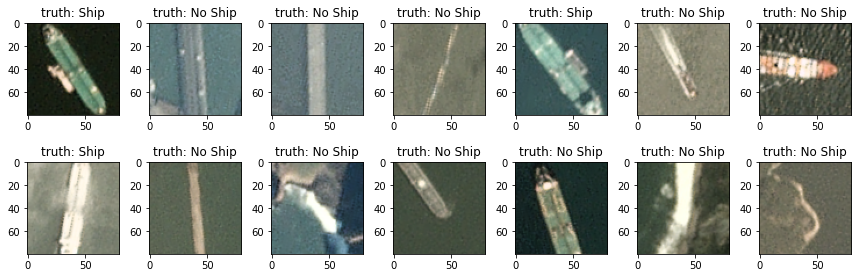

In [233]:
print_misclassified_test_predictions(rgb_label_test_results, rgb_splits)

## Ethical Considerations

This work has the potential for misuse. If this work is successful, it could be built upon to track domestic vehicles and other private modes of transportation. It may also enable malicious corporate practices if competitors track and then delay other ships. Both of these scenarios are enabled by access to real-time satellite data (rather than satellite data with high latency). These impacts could be mitigated with sufficient oversight and regulation of the organizations collecting and selling these images in real-time. 

## Conclusions

The overall performance on the test data is high for both models, which achieved accuracies greater than 98% and a losses less than 10%. In exploring the misclassifications, we have developed some hypotheses about the features the neural networks are using to make their classifications. In future work, we would explore salience mapping to further understand the patterns in the images that lead to classification and misclassifications. We would also like to explore iterating over larger scenes (background images) and overlaying bounding boxes on the predicted locations of ships. 